In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
DATA_DIR = "malaria"
TRAIN_JSON = os.path.join(DATA_DIR, "training.json")
TEST_JSON = os.path.join(DATA_DIR, "test.json")

In [5]:
class MalariaDataset(Dataset):
    def __init__(self, json_file, transform=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(DATA_DIR, item["image"]["pathname"].lstrip("/"))
        
        try:
            image = Image.open(image_path).convert("RGB")
        except:
            # If image not found, create a blank one for now
            # This is just a fallback - in production, handle this better
            print(f"Warning: Image not found: {image_path}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        # Check if there are any objects
        if len(item["objects"]) > 0:
            # Count occurrences of each category
            categories = [obj["category"] for obj in item["objects"]]
            # If there's at least one trophozoite, it's positive for malaria
            label = 1 if "trophozoite" in categories else 0
        else:
            # Default to negative if no objects
            label = 0
            
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
try:
    train_dataset = MalariaDataset(TRAIN_JSON, transform=transform)
    test_dataset = MalariaDataset(TEST_JSON, transform=transform)
    
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    # Calculate class distribution
    train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
    test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]
    
    print(f"Training class distribution: Negative: {train_labels.count(0)}, Positive: {train_labels.count(1)}")
    print(f"Test class distribution: Negative: {test_labels.count(0)}, Positive: {test_labels.count(1)}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

except Exception as e:
    print(f"Error loading datasets: {e}")

Training dataset size: 1208
Test dataset size: 120
Training class distribution: Negative: 612, Positive: 596
Test class distribution: Negative: 61, Positive: 59


In [7]:
class MalariaClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(MalariaClassifier, self).__init__()
        # Use a pre-trained ResNet18 model
        self.model = models.resnet18(pretrained=True)
        
        # Freeze early layers
        for param in list(self.model.parameters())[:-4]:
            param.requires_grad = False
            
        # Modify the final fully connected layer for our binary classification
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Initialize model
model = MalariaClassifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)


c:\Users\Zeshan\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Zeshan\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Zeshan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:07<00:00, 6.09MB/s]


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects.double() / len(test_dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Learning rate scheduler step based on validation loss
        scheduler.step(epoch_loss)
        
        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_malaria_model.pth')
    
    print(f'Best val Acc: {best_acc:.4f}')
    return model, history


In [ ]:
# Train model
try:
    trained_model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=5)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.legend()
    
    plt.savefig('training_results.png')
    
    print("Training complete. Model saved as 'best_malaria_model.pth'")
    
except Exception as e:
    print(f"Error during training: {e}")

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'])
    print("Classification Report:")
    print(report)
    
    return cm, report

# Evaluate the model
try:
    print("\nEvaluating model on test data:")
    cm, report = evaluate_model(trained_model, test_loader)
except Exception as e:
    print(f"Error during evaluation: {e}")


In [ ]:
def predict_image(image_path, model):
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, prediction = torch.max(output, 1)
        probs = torch.nn.functional.softmax(output, dim=1)
    
    class_names = ['Negative (Normal RBC)', 'Positive (Trophozoite/Malaria)']
    result = class_names[prediction.item()]
    confidence = probs[0][prediction.item()].item()
    
    return result, confidence

# Save the model
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'malaria_detection_model.pth')

print("Model saved successfully as 'malaria_detection_model.pth'")

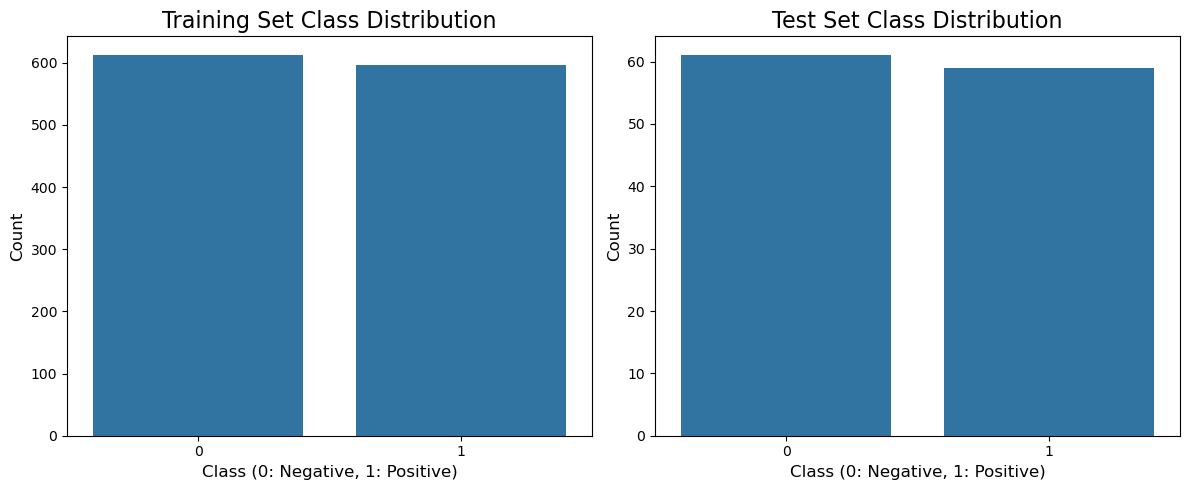

Error during visualization: name 'history' is not defined


In [30]:
# Add these imports at the top of your file if not already there
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.savefig('confusion_matrix.png')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores):
    plt.figure(figsize=(8, 6))
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.savefig('roc_curve.png')
    plt.show()
    
    return roc_auc

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_scores):
    plt.figure(figsize=(8, 6))
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)
    
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve', fontsize=16)
    plt.legend(loc="lower left", fontsize=12)
    plt.savefig('precision_recall_curve.png')
    plt.show()
    
    return average_precision

# Function to visualize sample predictions
def visualize_sample_predictions(model, test_loader, num_samples=8):
    model.eval()
    
    # Get a batch of images and labels
    all_images = []
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.shape[0]):
                all_images.append(images[i].cpu())
                all_labels.append(labels[i].item())
                all_preds.append(preds[i].item())
                all_probs.append(probs[i][1].item())  # Probability of positive class
    
    # Choose random samples
    indices = random.sample(range(len(all_images)), min(num_samples, len(all_images)))
    
    # Plot the samples
    fig = plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        ax = plt.subplot(2, 4, i + 1)
        
        # Denormalize the image
        img = all_images[idx].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        true_label = all_labels[idx]
        pred_label = all_preds[idx]
        prob = all_probs[idx]
        
        title_color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {'Pos' if true_label == 1 else 'Neg'}\nPred: {'Pos' if pred_label == 1 else 'Neg'} ({prob:.2f})", 
                  color=title_color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

# Function to plot learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train', marker='o')
    plt.plot(history['val_loss'], label='Validation', marker='s')
    plt.title('Loss over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train', marker='o')
    plt.plot(history['val_acc'], label='Validation', marker='s')
    plt.title('Accuracy over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

# Function to plot class distribution
def plot_class_distribution(train_labels, test_labels):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=train_labels)
    plt.title('Training Set Class Distribution', fontsize=16)
    plt.xlabel('Class (0: Negative, 1: Positive)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=test_labels)
    plt.title('Test Set Class Distribution', fontsize=16)
    plt.xlabel('Class (0: Negative, 1: Positive)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()

# Modified evaluation function to return scores for ROC curve
def evaluate_model_with_scores(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # For ROC curve
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'])
    print("Classification Report:")
    print(report)
    
    return cm, report, y_true, y_pred, y_scores

# Add this at the end of your script
if __name__ == "__main__":
    try:
        # Plot class distribution
        plot_class_distribution(train_labels, test_labels)
        
        # Plot learning curves
        plot_learning_curves(history)
        
        # Evaluate model with scores for ROC and PR curves
        cm, report, y_true, y_pred, y_scores = evaluate_model_with_scores(trained_model, test_loader)
        
        # Plot confusion matrix
        class_names = ['Negative', 'Positive']
        plot_confusion_matrix(cm, classes=class_names)
        plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
        
        # Plot ROC curve
        roc_auc = plot_roc_curve(y_true, y_scores)
        
        # Plot precision-recall curve
        avg_precision = plot_precision_recall_curve(y_true, y_scores)
        
        # Visualize sample predictions
        visualize_sample_predictions(trained_model, test_loader)
        
        # Create a comprehensive visualization dashboard
        plt.figure(figsize=(18, 12))
        gs = gridspec.GridSpec(2, 3)
        
        # Plot confusion matrix
        ax1 = plt.subplot(gs[0, 0])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        # Plot ROC curve
        ax2 = plt.subplot(gs[0, 1])
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        
        # Plot precision-recall curve
        ax3 = plt.subplot(gs[0, 2])
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        
        # Plot training history
        ax4 = plt.subplot(gs[1, 0])
        plt.plot(history['train_loss'], label='Train', marker='o')
        plt.plot(history['val_loss'], label='Validation', marker='s')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        ax5 = plt.subplot(gs[1, 1])
        plt.plot(history['train_acc'], label='Train', marker='o')
        plt.plot(history['val_acc'], label='Validation', marker='s')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Plot class distribution
        ax6 = plt.subplot(gs[1, 2])
        train_pos = train_labels.count(1)
        train_neg = train_labels.count(0)
        test_pos = test_labels.count(1)
        test_neg = test_labels.count(0)
        
        x = ['Training', 'Test']
        neg_counts = [train_neg, test_neg]
        pos_counts = [train_pos, test_pos]
        
        plt.bar(x, neg_counts, label='Negative')
        plt.bar(x, pos_counts, bottom=neg_counts, label='Positive')
        plt.title('Class Distribution')
        plt.ylabel('Count')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('malaria_detection_dashboard.png', dpi=300)
        plt.show()
        
        print("All visualizations completed and saved!")
        
    except Exception as e:
        print(f"Error during visualization: {e}")